# Actividad 1

### Realizaremos las siguientes actividades:
### a. Actividad 1 (5 puntos)
### i. Conectarse a hive
### ii. Se creará una tabla con la estructura necesaria para soportar el csv
### iii. Se indexará la tabla para soportar las consultas
### iv. Se cargarán los datos en la tabla
### v. Realice tres gráficos que representen la información ORDENADA, utilice
### consultas hive para traer los datos

### importa las librerías y crea la conexión con HIVE

In [45]:
import pyhive.hive as hive
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

conn = hive.Connection(host="localhost", port=10000, username="hadoop")

### Crear la tabla transaccional en ORC

In [2]:
with conn.cursor() as cursor:
    cursor.execute("""
        CREATE TABLE prueba (
          Period STRING,
          Birth_Death STRING,
          Region STRING,
          Count INT
        )
        STORED AS ORC
""")

### Ejecuta los comandos SET para configurar las propiedades transaccionales de la tabla creada.

In [4]:
cursor = conn.cursor()
cursor.execute("SET hive.txn.manager=org.apache.hadoop.hive.ql.lockmgr.DbTxnManager")
cursor.execute("SET hive.compactor.initiator.on=true")
cursor.execute("SET hive.compactor.worker.threads=1")

cursor.execute("ALTER TABLE prueba SET TBLPROPERTIES ('transactional'='true')")

### Creamos una tabla temporal llamada muerte_nac que contendrá los datos del csv.

In [43]:
drop_table_query = """
DROP TABLE IF EXISTS muerte_nac
"""
# Creación de una tabla en Hive
create_table_query = """
CREATE TABLE IF NOT EXISTS muerte_nac (
  Period STRING,
  Birth_Death STRING,
  Region STRING,
  Count INT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
STORED AS TEXTFILE

"""

with conn.cursor() as cursor:
    cursor.execute(create_table_query)

# Inserción de datos en la tabla
insert_query = "LOAD DATA INPATH '/lab2/muertes_por_region.csv' INTO TABLE muerte_nac";
with conn.cursor() as cursor:
    cursor.execute(insert_query)

# Consulta de datos en Hive
select_query = "SELECT * FROM muerte_nac limit 5"
with conn.cursor() as cursor:
    cursor.execute(select_query)
    results = cursor.fetchall()
    for row in results:
        print(row)

('Period', 'Birth_Death', 'Region', None)
('2005', 'Births', 'Northland region', 2067)
('2005', 'Births', 'Auckland region', 20745)
('2005', 'Births', 'Waikato region', 5667)
('2005', 'Births', 'Bay of Plenty region', 3771)


### Seguidamente se cargaron los datos de esa tabla a la tabla ORC que soporta ACID.

In [10]:
cursor.execute("""
    INSERT INTO TABLE prueba
    SELECT * FROM muerte_nac
""")

### Verificando los registros de la tabla prueba

In [44]:
select_query = "SELECT * FROM prueba limit 5"
with conn.cursor() as cursor:
 cursor.execute(select_query)
 results = cursor.fetchall()
 for row in results:
     print(row)

('Period', 'Birth_Death', 'Region', None)
('2005', 'Births', 'Northland region', 2067)
('2005', 'Births', 'Auckland region', 20745)
('2005', 'Births', 'Waikato region', 5667)
('2005', 'Births', 'Bay of Plenty region', 3771)


### Crea la Vista Materializada (my_view).-

In [14]:
query = """
    CREATE MATERIALIZED VIEW my_view
    AS
    SELECT *
    FROM prueba
"""
cursor = conn.cursor()
cursor.execute(query)


### Consulta la Vista Materializada (my_view).-

In [16]:
select_query = "SELECT * FROM my_view limit 5"
with conn.cursor() as cursor:
 cursor.execute(select_query)
 results = cursor.fetchall()
 for row in results:
     print(row)

('Period', 'Birth_Death', 'Region', None)
('2005', 'Births', 'Northland region', 2067)
('2005', 'Births', 'Auckland region', 20745)
('2005', 'Births', 'Waikato region', 5667)
('2005', 'Births', 'Bay of Plenty region', 3771)


### Data y Gráfico 1

In [33]:
g1 = """SELECT Region, sum(Count) as conteo_nacimiento FROM my_view  
                   where Birth_Death='Births' and Period =2005  
                   GROUP BY Region  
                   order by sum(Count) desc limit 6"""

with conn.cursor() as cursor:  
    cursor.execute(g1)     
    column_names = [column[0] for column in cursor.description] 
    
    results_g1 = cursor.fetchall()
    print(column_names)   
    for row in results_g1:
        print(row)

['region', 'conteo_nacimiento']
('New Zealand', 57747)
('Auckland region', 20745)
('Canterbury region', 6603)
('Wellington region', 6225)
('Waikato region', 5667)
('Bay of Plenty region', 3771)


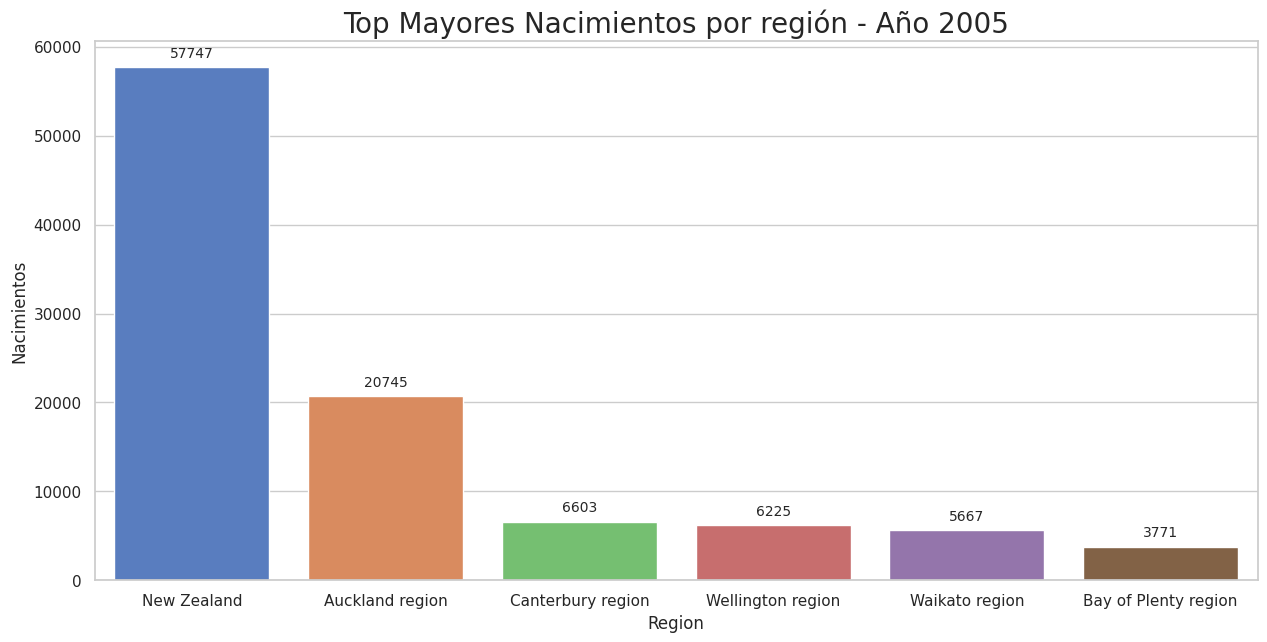

In [34]:
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Obtén los datos de la consulta 
region = [row[0] for row in results_g1] 
nacimientos = [row[1] for row in results_g1]

# Configura visualización de gráficos
sns.set(style="whitegrid")

# Crea el gráfico
plt.figure(figsize=(15,7))
bars = sns.barplot(x=region, y=nacimientos, 
                   palette='muted')

# Etiqueta ejes 
bars.set(xlabel='Region', ylabel='Nacimientos')

# Título
plt.title('Top Mayores Nacimientos por región - Año 2005'\
          ,fontsize=20)


# Etiqueta barras        
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),  
                  (bar.get_x() + bar.get_width() / 2, 
                   bar.get_height()), ha = 'center', 
                  va = 'center', 
                  size = 10, 
                  xytext = (0, 10),
                  textcoords = 'offset points')

# Mostrar gráfico
plt.show()

### Data y Gráfico 2

In [36]:
g2 = """SELECT Region, sum(Count) as conteo_muerte FROM my_view  
                   where Birth_Death='Deaths' and Period =2020  
                   GROUP BY Region  
                   order by sum(Count) desc limit 6"""

with conn.cursor() as cursor:  
    cursor.execute(g2)     
    column_names = [column[0] for column in cursor.description] 
    
    results_g2 = cursor.fetchall()
    print(column_names)   
    for row in results_g2:
        print(row)

['region', 'conteo_muerte']
('New Zealand', 32613)
('Auckland region', 8328)
('Canterbury region', 4476)
('Waikato region', 3357)
('Wellington region', 3282)
('Bay of Plenty region', 2526)


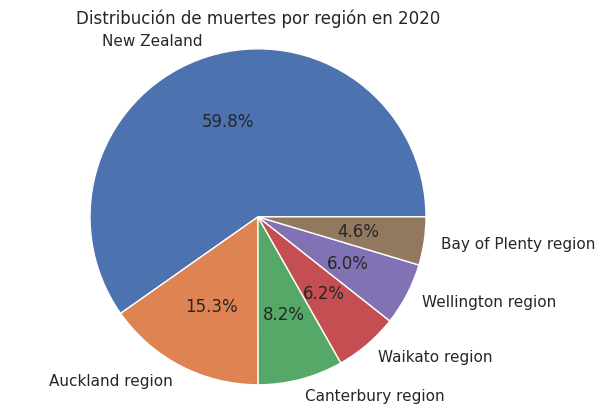

In [37]:
import matplotlib.pyplot as plt

# Obtener los datos de la consulta
data = [(row[0], row[1]) for row in results_g2]

# Extraer las etiquetas y los valores
labels = [row[0] for row in data]
values = [row[1] for row in data]

# Crear el gráfico de pastel
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%')

# Personalizar el gráfico
ax.set_title('Distribución de muertes por región en 2020')
ax.axis('equal')

# Mostrar el gráfico
plt.show()


### Data y Gráfico 3

In [38]:
g3 = """SELECT Period, sum(Count) as Nacimientos FROM my_view  
                   where Birth_Death='Births' and Period BETWEEN 2018 AND 2022
                   GROUP BY Period  
                   order by Period"""
                   
with conn.cursor() as cursor:  
    cursor.execute(g3)     
    column_names = [column[0] for column in cursor.description] 
    
    results_3 = cursor.fetchall()
    print(column_names)   
    for row in results_3:
        print(row)

['period', 'nacimientos']
('2018', 116016)
('2019', 119250)
('2020', 115122)
('2021', 117306)
('2022', 117768)


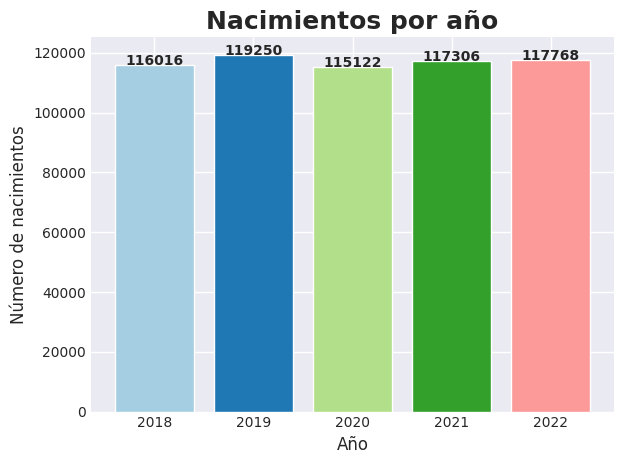

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de Seaborn
sns.set_style('darkgrid')

# Obtener los datos de la consulta
data = [(row[0], row[1]) for row in results]

# Extraer las etiquetas y los valores
labels = [row[0] for row in data]
values = [row[1] for row in data]

# Definir la paleta de colores
palette = sns.color_palette('Paired', len(values))

# Crear el gráfico de barras
fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=palette)

# Personalizar el gráfico
ax.set_title('Nacimientos por año', fontsize=18, fontweight='bold')
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Número de nacimientos', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)

# Añadir etiquetas en cada barra
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 10, str(values[i]), ha='center', fontsize=10, fontweight='bold')

# Ajustar espacios
plt.tight_layout()

# Mostrar el gráfico
plt.show()